<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Lab04_Ecualizacion_Suavizado_Aritmetica_Mascaras_PixelOps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Ecualización de histograma, Suavizado de ruido, Operaciones aritméticas, Máscaras y Transformaciones de píxeles

In [ ]:
# === Configuración del entorno ===
!pip -q install opencv-python-headless pillow

import cv2, numpy as np, matplotlib.pyplot as plt, os
from PIL import Image

def imshow(img, title=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    if img is None:
        plt.text(0.5,0.5,"Imagen None", ha='center', va='center'); plt.axis('off'); return
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off'); plt.show()

def show_row(imgs, titles=None, figsize=(14,4)):
    n = len(imgs); plt.figure(figsize=figsize)
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, n, i)
        if im is None:
            plt.text(0.5,0.5,"None", ha='center', va='center'); plt.axis('off'); continue
        if im.ndim == 2: plt.imshow(im, cmap='gray')
        else: plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles: plt.title(titles[i-1])
        plt.axis('off')
    plt.show()

print("Entorno listo. OpenCV:", cv2.__version__)

Entorno listo. OpenCV: 4.12.0


## 1) Adquisición de imágenes


--2025-09-15 04:26:40--  https://i.sstatic.net/J13Wn.jpg
Resolving i.sstatic.net (i.sstatic.net)... 104.18.41.33, 172.64.146.223
Connecting to i.sstatic.net (i.sstatic.net)|104.18.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444265 (434K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 433.85K  --.-KB/s    in 0.02s   

2025-09-15 04:26:40 (17.8 MB/s) - ‘imagen.jpg’ saved [444265/444265]



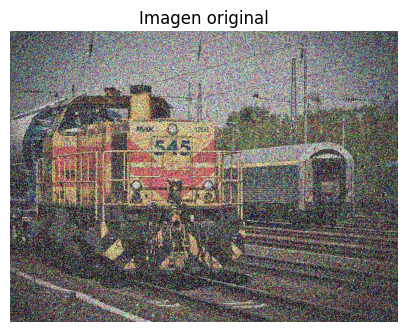

(720, 960, 3)

In [ ]:
!wget https://i.sstatic.net/J13Wn.jpg -O imagen.jpg

paths = ['imagen.jpg']

img = cv2.imread(paths[0], cv2.IMREAD_COLOR)

imshow(img, "Imagen original")

img.shape


## 2) Ecualización de histograma (teoría + práctica)

### 2.1 Fundamentos (teoría breve)
Dada una imagen en **grises** con niveles $ r \in [0, L-1] $ (típicamente $ L=256 $), el **histograma** $ h(r_k) $ cuenta ocurrencias de cada nivel. La **función de distribución acumulada (CDF)** es:

$
c(r_k) = \sum_{j=0}^{k} \frac{h(r_j)}{N}
$

donde $ N $ es el total de píxeles. La **ecualización** busca un mapeo $ s = T(r) $ tal que la CDF de salida sea aproximadamente lineal (distribución uniforme):

$
s = T(r) = (L-1) \cdot c(r)
$

Esto **expande el contraste** donde hay concentración de intensidades.

- **Global (`cv2.equalizeHist`)**: aplica el mapeo sobre toda la imagen (solo grises).
- **CLAHE**: ecualización adaptativa por bloques (tiles) con límite de contraste (*clip limit*), útil con **iluminación no uniforme**.

> Nota: para color, es preferible ecualizar **en un espacio que separe luminancia** (e.g., YCrCb: ecualizar canal Y).


In [ ]:

def plot_hist_gray(gray, title="Histograma (grises)"):
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).ravel()
    plt.figure(figsize=(6,3))
    plt.plot(hist); plt.title(title); plt.xlabel("Intensidad"); plt.ylabel("Frecuencia"); plt.show()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eq = cv2.equalizeHist(gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq_clahe = clahe.apply(gray)

    show_row([gray, eq, eq_clahe], ["Gris original", "EqualizeHist (global)", "CLAHE"])
    plot_hist_gray(gray, "Histograma - original")
    plot_hist_gray(eq, "Histograma - equalizeHist")
    plot_hist_gray(eq_clahe, "Histograma - CLAHE")


## 3) Suavizado de ruido (teoría + práctica)

### 3.1 Fundamentos
- **Promedio (`cv2.blur`)**: media aritmética en ventana $k\times k$. Suaviza ruido y bordes por igual.
- **Gaussiano (`cv2.GaussianBlur`)**: pesos gausianos (más peso al centro); aspecto más natural.
- **Mediana (`cv2.medianBlur`)**: excelente para **ruido sal y pimienta** (reemplaza por la mediana local).
- **Bilateral (`cv2.bilateralFilter`)**: suaviza preservando **bordes** (combina distancia espacial e intensidad).

> Selección rápida: sal-pimienta → mediana; preservación de bordes → bilateral; suavizado general → gaussiano.


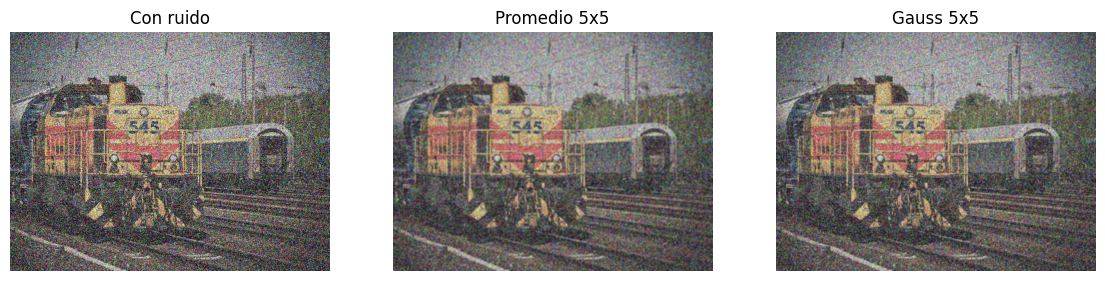

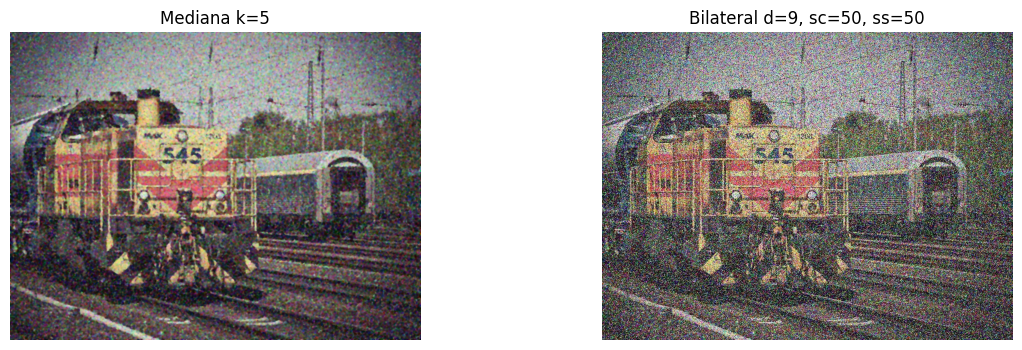

In [ ]:
    # simular ruido sal/pimienta
    noisy = img.copy()
    rng = np.random.default_rng(0)
    mask_salt = rng.random(img.shape[:2]) < 0.01
    mask_pepper = rng.random(img.shape[:2]) < 0.01
    noisy[mask_salt] = (255,255,255)
    noisy[mask_pepper] = (0,0,0)

    blur = cv2.blur(noisy, (5,5))
    gauss = cv2.GaussianBlur(noisy, (5,5), sigmaX=1.2)
    median = cv2.medianBlur(noisy, 5)
    bilat = cv2.bilateralFilter(noisy, d=9, sigmaColor=50, sigmaSpace=50)

    show_row([noisy, blur, gauss], ["Con ruido", "Promedio 5x5", "Gauss 5x5"])
    show_row([median, bilat], ["Mediana k=5", "Bilateral d=9, sc=50, ss=50"])

# Tarea 0

¿Qué filtro brinda mejores resultados eliminado el ruido?

¿Qué filtro elimina detalles finos al eleiminar el ruido?

In [ ]:
img1 = img
img2 = median


## 4) Operaciones aritméticas entre imágenes (teoría + práctica)

### 4.1 Fundamentos
- **Suma / Resta**: $ I = I_1 \pm I_2 $. Útil para **combinación**, **resaltado de cambios** o **corrección**.
- **Combinación ponderada**: $ I = \alpha I_1 + (1-\alpha) I_2 $ (`cv2.addWeighted`).
- **Brillo y contraste** (transformación puntual): $ I' = \alpha I + \beta $ (escala y desplazamiento).

> Las operaciones se hacen por canal y clipean a $[0,255]$ en 8 bits.


In [ ]:
def to_size(img, size):
    return cv2.resize(img, (size[1], size[0]), interpolation=cv2.INTER_LINEAR)

    h, w = img1.shape[:2]
    img2r = to_size(img2, (h, w))

    add = cv2.add(img1, img2r)
    sub = cv2.subtract(img1, img2r)
    blend = cv2.addWeighted(img1, 0.6, img2r, 0.4, 0)

    show_row([img1, img2r, add], ["Img1", "Img2 (redimensionada)", "Suma (add)"])
    show_row([sub, blend], ["Resta (subtract)", "Mezcla (addWeighted 0.6/0.4)"])


## 5) Operaciones con máscaras (teoría + práctica)

### 5.1 Fundamentos
Una **máscara** es una imagen binaria (0/255) que **selecciona** píxeles a conservar o modificar.  
- Creación: umbrales (`cv2.threshold`, `cv2.inRange`), condiciones sobre HSV, etc.  
- Aplicación: `cv2.bitwise_and`, `cv2.bitwise_or`, `cv2.copyTo`.

**Ejemplos de uso**: segmentar por color, ocultar fondos, combinar regiones específicas, contar píxeles de interés.


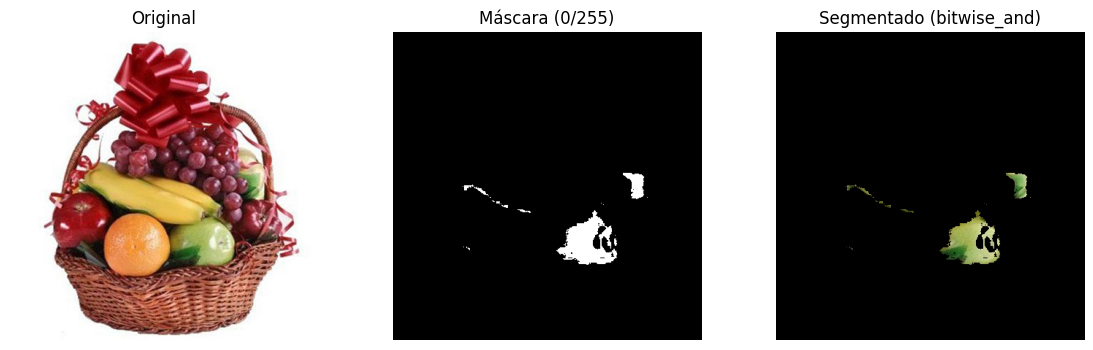

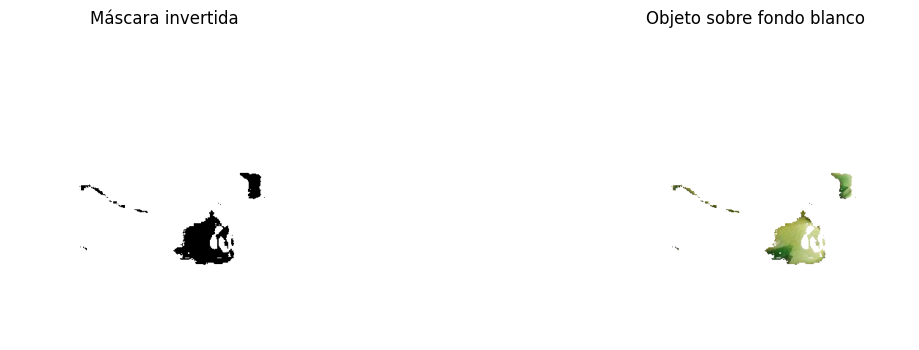

In [ ]:
    img = !wget https://floreriasanisidro.com.pe/wp-content/uploads/2022/09/COD-CF003_3.jpg -O canasta.jpg

    img = cv2.imread("canasta.jpg", cv2.IMREAD_COLOR)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ejemplo: seleccionar tonos verdes (ajusta a tus imágenes)
    lower = np.array([30, 60, 60], dtype=np.uint8)
    upper = np.array([60, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)  # 0/255

    # aplicar máscara
    segmented = cv2.bitwise_and(img, img, mask=mask)

    # invertir máscara y componer sobre fondo blanco
    mask_inv = cv2.bitwise_not(mask)
    white_bg = np.full_like(img, 255)
    bg_white = cv2.bitwise_and(white_bg, white_bg, mask=mask_inv)
    fg_obj = cv2.bitwise_and(img, img, mask=mask)
    composited = cv2.add(bg_white, fg_obj)

    show_row([img, mask, segmented], ["Original", "Máscara (0/255)", "Segmentado (bitwise_and)"])
    show_row([mask_inv, composited], ["Máscara invertida", "Objeto sobre fondo blanco"])

# Tarea 1

Modificando lower y upper (que están en HSV) deberás segmentar solo los plátanos.


## 6) Transformaciones de píxeles (teoría + práctica)

### 6.1 Fundamentos
Son **transformaciones puntuales** $( I' = f(I) $ aplicadas por píxel:
- **Brillo/Contraste lineal**: $ I' = \alpha I + \beta $ (clipeo a [0,255]).
- **Gamma**: $ I' = 255\,(I/255)^{\gamma} $ $(\gamma<1$ aclara; $\gamma>1$ oscurece).
- **Logarítmica**: $ I' = c \cdot \log(1 + I) $, comprime dinámicas altas.
- **Umbralización**: binariza con un umbral fijo o adaptativo (prepara máscaras o OCR).


In [ ]:
def adjust_contrast_brightness(img, alpha=1.2, beta=20):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def gamma_correction(img, gamma=1.5):
    inv = 1.0 / gamma
    table = (np.arange(256) / 255.0) ** inv
    table = np.clip(table * 255.0, 0, 255).astype(np.uint8)
    return cv2.LUT(img, table)

def log_transform(gray):
    gray_f = gray.astype(np.float32)
    c = 255 / np.log(1 + np.max(gray_f))
    out = c * np.log(1 + gray_f)
    return np.clip(out, 0, 255).astype(np.uint8)

    name, img = imgs[0]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    lin = adjust_contrast_brightness(img, alpha=1.3, beta=20)
    gam = gamma_correction(img, gamma=1.7)
    logt = log_transform(gray)

    _, th_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th_adp = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, blockSize=21, C=5)

    show_row([img, lin, gam], ["Original", "Lineal (α=1.3, β=20)", "Gamma (γ=1.7)"])
    show_row([gray, logt], ["Gris", "Logarítmica (grises)"])
    show_row([th_bin, th_adp], ["Umbral Otsu", "Umbral Adaptativo"])


img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

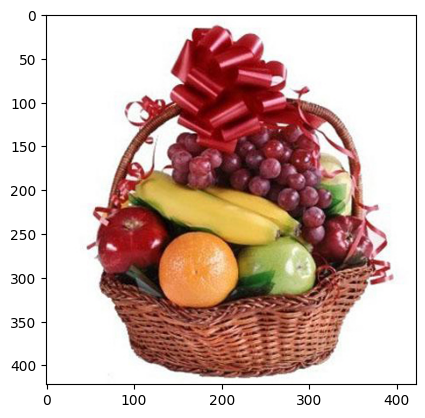

In [ ]:
#visualizar img_RGB con plot
plt.imshow(img_RGB)
plt.show()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
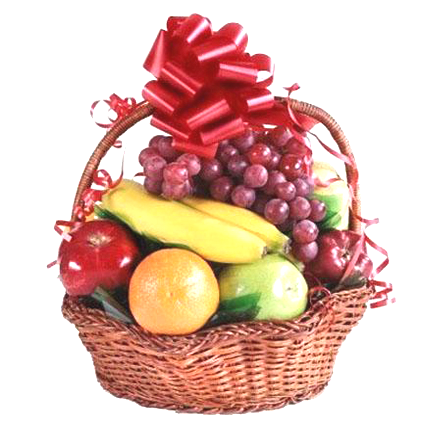

In [ ]:
adjust_contrast_brightness(img_RGB)

In [ ]:
# Tarea 2
¿Cómo funciona matemáticamente el ajuste de brillo y por qué da esos resultados?

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
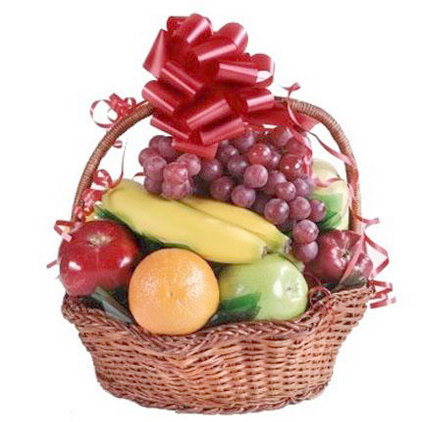

In [ ]:
gamma_correction(img_RGB)

# Tarea 3
¿Cómo funciona matemáticamente el ajuste de gamma y por qué da esos resultados?

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
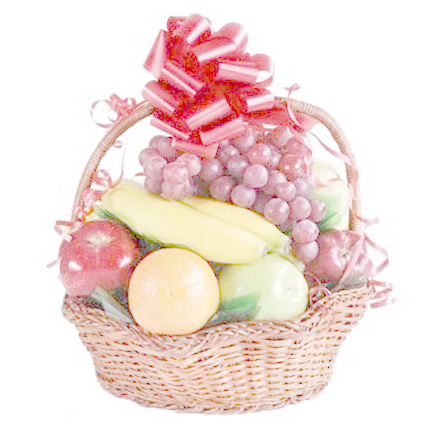

In [ ]:
log_transform(img_RGB)

# Tarea 4
¿Cómo funciona matemáticamente el la transformación LOG y por qué da esos resultados?